In [3]:
import jax

import jax.numpy as np
import numpy as np
import transforms3d as t3d

from scipy.spatial import KDTree
from tqdm import tqdm
from utils import read_canonical_model, load_pc, visualize_icp_result
from tools import sync_time_stamps

In [23]:
# Scan matching
dataset = 21
  
with np.load("../../data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

with np.load("../../data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]     # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans

    # Clipping the ranges
    lidar_ranges[lidar_ranges < lidar_range_min] = 0
    lidar_ranges[lidar_ranges > lidar_range_max] = 0
    lidar_ranges = lidar_ranges.T

with np.load("../../data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

In [ ]:
# Extracting point clouds from lidar data
def extract_pc(lidar_ranges, lidar_angle_increment):
    pc = []
    for i in range(len(lidar_ranges)):
        ranges = lidar_ranges[i]
        angles = np.arange(lidar_angle_min, lidar_angle_max + 1e-6, lidar_angle_increment)
        x = ranges * np.cos(angles)
        y = ranges * np.sin(angles)
        z = np.zeros_like(x)

        # Removing all zeros
        x = x[ranges != 0]
        y = y[ranges != 0]
        z = z[ranges != 0]
        pc.append(np.stack([x, y, z], axis=1))
    return pc

In [25]:
pc = extract_pc(lidar_ranges, lidar_angle_increment)
pose = np.eye(4)
# Visualize the estimated result
visualize_icp_result(pc[0], pc[0], pose)

/var/folders/1y/87vkwc9x32lcthv8n1nxqhz80000gn/T/ipykernel_50438/1867335340.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  angles = np.arange(lidar_angle_min, lidar_angle_max + 1e-6, lidar_angle_increment)


In [26]:
def velocity_right_encoder(counts, timestamps):
    delta_t = timestamps[1:] - timestamps[:-1]
    delta_t = [timestamps[1] - timestamps[0]] + list(delta_t)
    return ((counts[0, :] + counts[2, :]) / 2 * 0.0022) / delta_t

def velocity_left_encoder(counts, timestamps):
    delta_t = timestamps[1:] - timestamps[:-1]
    delta_t = [timestamps[1] - timestamps[0]] + list(delta_t)
    return ((counts[1, :] + counts[3, :]) / 2 * 0.0022) / delta_t

In [27]:
def sync_time_stamps(t1, t2):
    t1 = np.array(t1)
    t2 = np.array(t2)
    t1 = t1.reshape(-1, 1)
    t2 = t2.reshape(1, -1)
    return np.argmin(np.abs(t1 - t2), axis=1)

synced_encoder_stamps = sync_time_stamps(imu_stamps, lidar_stamps)
# synced_lidar_stamps = sync_time_stamps(imu_stamps, lidar_stamps)

v_left = velocity_left_encoder(encoder_counts, encoder_stamps)
v_right = velocity_right_encoder(encoder_counts, encoder_stamps)

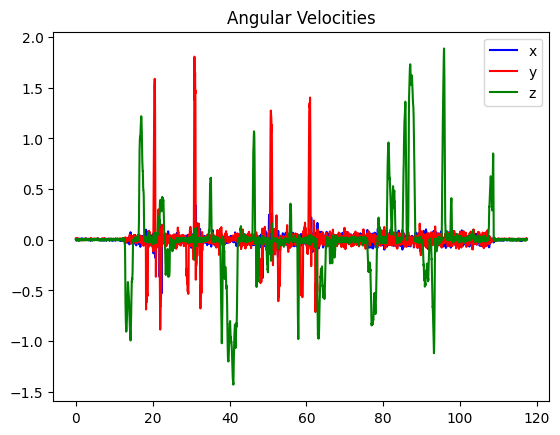

In [28]:
import matplotlib.pyplot as plt
# Plotting the x, y, z velocities
plt.title("Angular Velocities")
plt.plot(imu_stamps - imu_stamps[0], imu_angular_velocity[0], color='blue')
plt.plot(imu_stamps - imu_stamps[0], imu_angular_velocity[1], color='red')
plt.plot(imu_stamps - imu_stamps[0], imu_angular_velocity[2], color='green')
plt.legend(['x', 'y', 'z'])
plt.show()

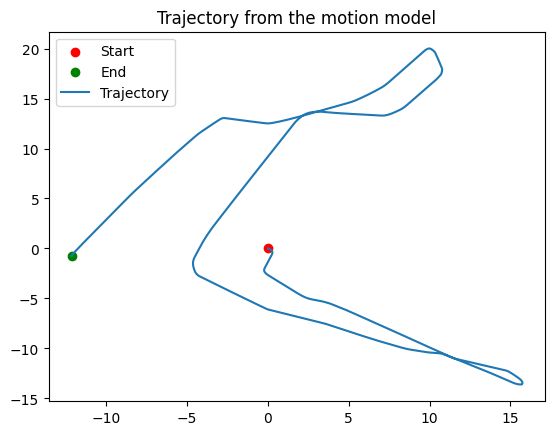

In [29]:
# Motion model
axel_length = 0.31115 # meters
wheel_diameter = 0.254 # meters

def motion_model(pose, v, omega, dt):
    x, y, theta = pose
    x += v * np.cos(theta) * dt
    y += v * np.sin(theta) * dt
    theta += omega * dt
    return np.array([x, y, theta])

pose = np.zeros((3))

x_traj = [0]
y_traj = [0]
poses = []

for i in range(len(imu_angular_velocity[2])):
    omega = imu_angular_velocity[2][i] # yaw angular velocity
    dt = imu_stamps[i] - imu_stamps[i - 1]
    encoder_ind = synced_encoder_stamps[i]
    v = (v_left[encoder_ind] + v_right[encoder_ind]) / 2
    pose = motion_model(pose, v, omega, dt)
    poses.append(pose)

poses = np.array(poses).T
# Beginning point
plt.scatter(0, 0, c='r')
# Ending point
plt.scatter(pose[0], pose[1], c='g')
plt.title("Trajectory from the motion model")
plt.plot(poses[0], poses[1])
plt.legend(["Start", "End", "Trajectory"])
plt.show()


In [30]:
from tools import ICP
# Using the ICP algorithm to estimate the pose initilized with the motion model
icp_poses = []
all_poses = []

init_pose = np.eye((4))
icp_poses.append(init_pose[:2, 3])


synced_lidar_stamps = sync_time_stamps(lidar_stamps, imu_stamps)

for i in tqdm(range(1, len(lidar_stamps))):
    imu_ind = synced_lidar_stamps[i]

    # Initial guess
    x, y, theta = poses[:, imu_ind] - poses[:, imu_ind - 1]

    R, p = ICP(pc[i], pc[i - 1], t3d.euler.euler2mat(0, 0, theta), np.array([x, y, 0]))

    new_pose = np.eye(4)
    new_pose[:3, :3] = R
    new_pose[:3, 3] = p

    init_pose = init_pose @ new_pose
    
    all_poses.append(init_pose)
    icp_poses.append(init_pose[:2, 3])

icp_poses = np.array(icp_poses).T

100%|██████████| 4784/4784 [2:09:24<00:00,  1.62s/it]  


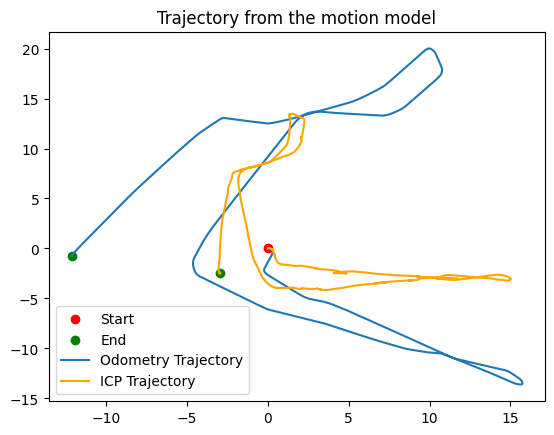

In [31]:
# Beginning point
plt.scatter(0, 0, c='red')
# Ending point
plt.scatter(pose[0], pose[1], c='green')
plt.title("Trajectory from the motion model")
plt.plot(poses[0], poses[1],)
plt.plot(icp_poses[0], icp_poses[1], c='orange')
plt.scatter(icp_poses[0, -1], icp_poses[1, -1], c='green')
plt.legend(["Start", "End", "Odometry Trajectory", "ICP Trajectory"])
plt.show()

(11730,) (4785,)
1298881995.438197 1298882112.795965
1298881994.982633 1298882114.350636


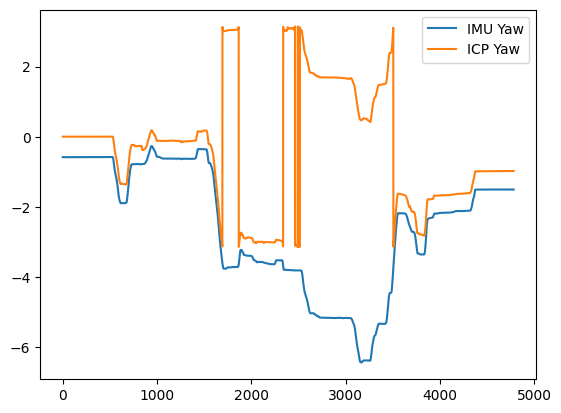

In [32]:
print(imu_stamps.shape, lidar_stamps.shape)
print(np.min(imu_stamps), np.max(imu_stamps))
print(np.min(lidar_stamps), np.max(lidar_stamps))


synced1_lidar_stamps = sync_time_stamps(lidar_stamps, imu_stamps)
yaws = []
thetas = []
for i in range(len(all_poses)):
    imu_ind = synced1_lidar_stamps[i]
    thetas.append(poses[2, imu_ind])

theta = np.array(thetas)

for i in range(len(all_poses)):
    angles = t3d.euler.mat2euler(all_poses[i][:3, :3])
    yaws.append(angles[2])
yaws = np.array(yaws)

plt.plot(theta)
plt.plot(yaws)
plt.legend(["IMU Yaw", "ICP Yaw"])

In [33]:
# Saving the icp poses
np.save(f"icp_poses_{dataset}.npy", all_poses)